In [10]:
# ---------------------------------------------------------
# 0 · Load processed CSVs
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf


base_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed"

ct   = pd.read_csv(os.path.join(base_path, "ct_master.csv"))
mri  = pd.read_csv(os.path.join(base_path, "mri_master.csv"))
endo = pd.read_csv(os.path.join(base_path, "endo_master.csv"))

# Add modality labels
ct["modality"]   = "CT"
mri["modality"]  = "MRI"
endo["modality"] = "Endoscopy"

# Concatenate
df = pd.concat([ct, mri, endo], ignore_index=True)
print("Combined shape:", df.shape)
display(df.head())

Combined shape: (979543, 30)


,icb_code,icb_name,lsoa_code,nhs_region,site_code,site_name,provider_code,provider_name,activity_month,financial_year,...,subcancer_flag,referring_org_code,referring_org_name,age_band,age_mid,modality_clean,ps_bucket,is_ct,is_mri,is_endo
0,11X,NHS SOMERSET ICB - 11X,E01029112,Head structure (body structure),RH5A8,MUSGROVE PARK HOSPITAL (RH5A8),RH5,SOMERSET NHS FOUNDATION TRUST,202403,2023/24,...,NaN,RH5,SOMERSET NHS FOUNDATION TRUST (RH5),40-44,NaN,CT,Emergency/A&E,True,False,False
1,11X,NHS SOMERSET ICB - 11X,E01029135,Head structure (body structure),RH5A8,MUSGROVE PARK HOSPITAL (RH5A8),RH5,SOMERSET NHS FOUNDATION TRUST,202411,2024/25,...,NaN,RH5,SOMERSET NHS FOUNDATION TRUST (RH5),40-44,NaN,CT,Inpatient,True,False,False
2,11X,NHS SOMERSET ICB - 11X,E01029237,Head structure (body structure),RH504,GREENFIELDS DAY CENTRE (RH504),RH5,SOMERSET NHS FOUNDATION TRUST,202409,2024/25,...,NaN,RH5,SOMERSET NHS FOUNDATION TRUST (RH5),50-54,NaN,CT,Emergency/A&E,True,False,False
3,11X,NHS SOMERSET ICB - 11X,E01029255,NaN,RH504,GREENFIELDS DAY CENTRE (RH504),RH5,SOMERSET NHS FOUNDATION TRUST,202406,2024/25,...,NaN,RH5,SOMERSET NHS FOUNDATION TRUST (RH5),55-59,NaN,CT,Elective/GP,True,False,False
4,11X,NHS SOMERSET ICB - 11X,E01029205,Head structure (body structure),RH504,GREENFIELDS DAY CENTRE (RH504),RH5,SOMERSET NHS FOUNDATION TRUST,202408,2024/25,...,NaN,RH5,SOMERSET NHS FOUNDATION TRUST (RH5),85+,NaN,CT,Emergency/A&E,True,False,False


In [41]:
# ---------------------------------------------------------
# 0 · Cap age at 90 to remove noise in 90+ range
# ---------------------------------------------------------
df = df[df["age"] <= 90]

# ---------------------------------------------------------
# 1 · Group by continuous age × modality × source × cancer
# ---------------------------------------------------------
grouped = (
    df.groupby(["modality", "age", "cancer_flag", "patient_source"])
      .size()
      .reset_index(name="count")
)
print("Grouped shape:", grouped.shape)
display(grouped.head())

# ---------------------------------------------------------
# 2 · Convert predictors to categorical
# ---------------------------------------------------------
df_model = grouped.copy()
for col in ["modality", "patient_source"]:
    df_model[col] = df_model[col].astype("category")
df_model["cancer_flag"] = df_model["cancer_flag"].astype(int)


Grouped shape: (2709, 5)


,modality,age,cancer_flag,patient_source,count
0,CT,0.0,False,Accident and Emergency Department (this Health...,211
1,CT,0.0,False,Admitted Patient Care - Day case (this Health ...,8
2,CT,0.0,False,Admitted Patient Care - Inpatient (this Health...,398
3,CT,0.0,False,GP Direct Access,2
4,CT,0.0,False,Other,7


In [45]:
# ---------------------------------------------------------
# 3 · Fit Poisson GLM with continuous age (capped at 90)
# ---------------------------------------------------------
# Re-cap age for safety
df_model = df_model[df_model["age"] <= 90]

import statsmodels.formula.api as smf
import statsmodels.api as sm

formula = "count ~ age + modality + cancer_flag + patient_source"
model_poiss = smf.glm(
    formula=formula,
    data=df_model,
    family=sm.families.Poisson()
).fit()

print(model_poiss.summary())

# --- Predict on original data ---
df_model["predicted"] = model_poiss.predict(df_model)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 2709
Model:                            GLM   Df Residuals:                     2698
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6322e+05
Date:                Wed, 02 Jul 2025   Deviance:                   5.1136e+05
Time:                        16:05:34   Pearson chi2:                 7.18e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

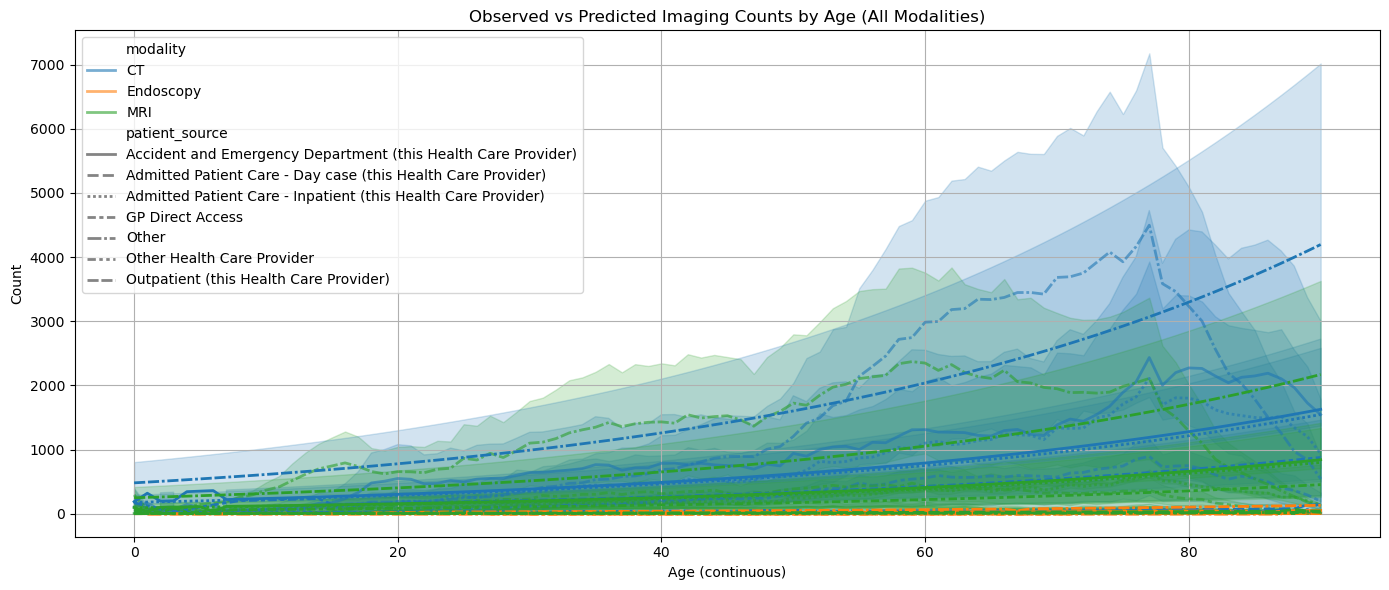

In [46]:
# ---------------------------------------------------------
# 4 · Plot: Overall Observed vs Predicted Counts by Age
# ---------------------------------------------------------
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=df_model,
    x="age",
    y="count",
    hue="modality",
    style="patient_source",
    linewidth=2,
    alpha=0.6,
    legend="brief"
)

sns.lineplot(
    data=df_model,
    x="age",
    y="predicted",
    hue="modality",
    style="patient_source",
    linewidth=2,
    linestyle="--",
    dashes=True,
    legend=False  # Avoid double legend
)

plt.title("Observed vs Predicted Imaging Counts by Age (All Modalities)")
plt.xlabel("Age (continuous)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

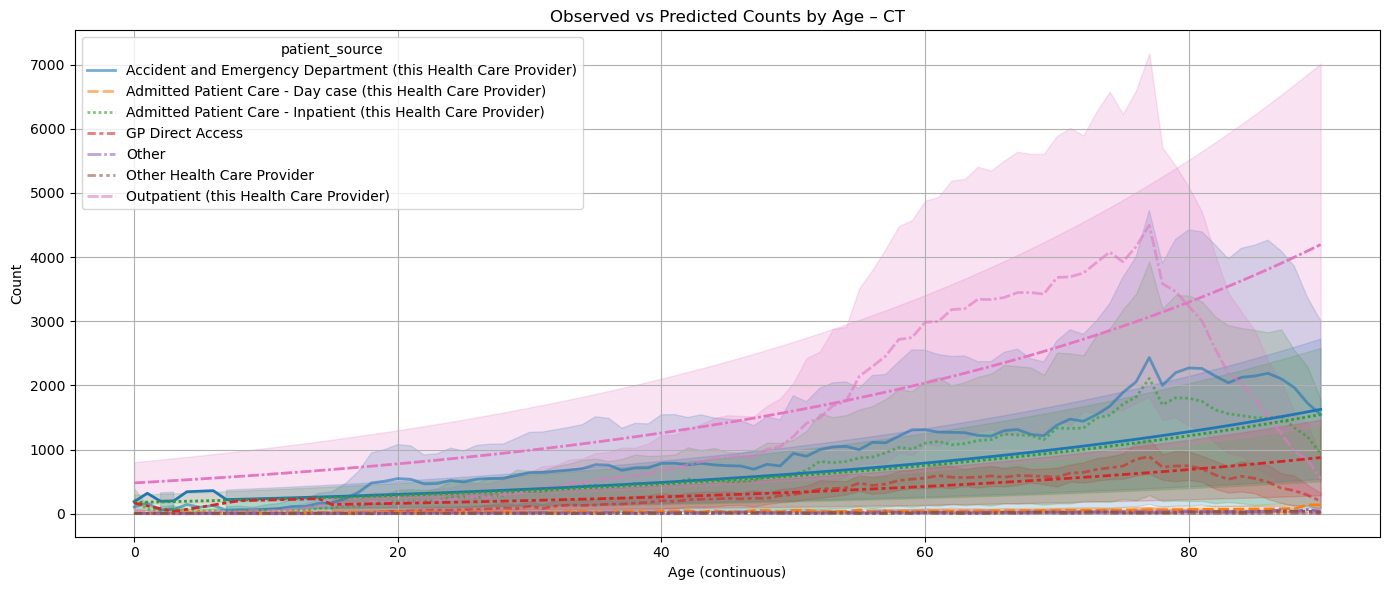

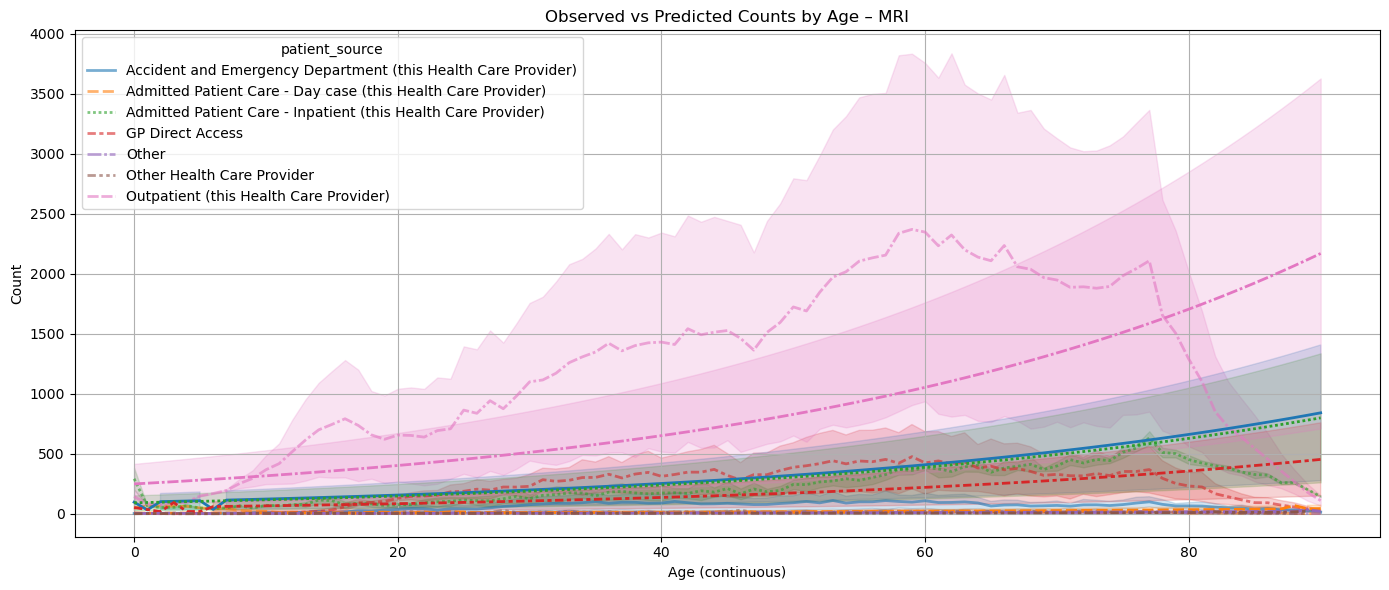

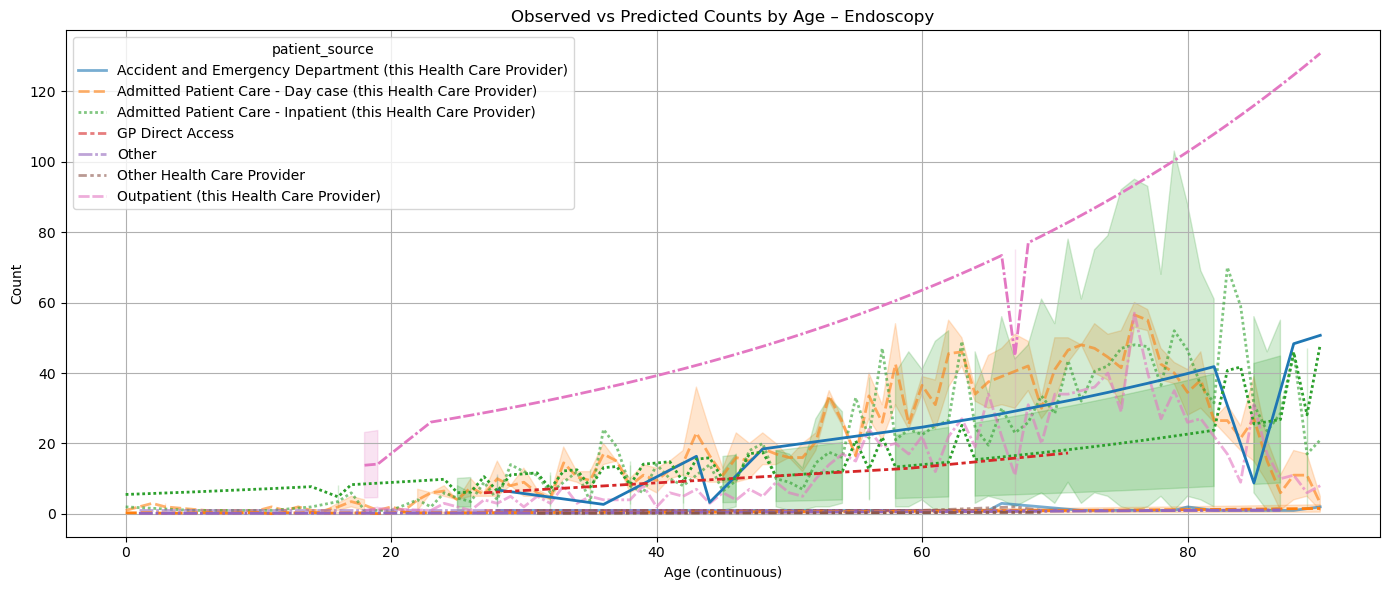

In [47]:
# ---------------------------------------------------------
# 5 · Plot: One Figure per Modality
# ---------------------------------------------------------
modalities = ['CT', 'MRI', 'Endoscopy']

for modality in modalities:
    plt.figure(figsize=(14, 6))

    df_subset = df_model[df_model['modality'] == modality]

    sns.lineplot(
        data=df_subset,
        x="age",
        y="count",
        hue="patient_source",
        linewidth=2,
        alpha=0.6,
        style="patient_source"
    )

    sns.lineplot(
        data=df_subset,
        x="age",
        y="predicted",
        hue="patient_source",
        linewidth=2,
        linestyle="--",
        dashes=True,
        legend=False,
        style="patient_source"
    )

    plt.title(f"Observed vs Predicted Counts by Age – {modality}")
    plt.xlabel("Age (continuous)")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()